# Import libraries

In [1]:
!pip install mne


[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Usefull libraries 
from scipy.io import loadmat # Load .mat file 
from scipy.signal import welch
from scipy.signal import stft
import numpy as np, os, sys, joblib
import re
from os.path import dirname, join as pjoin
import matplotlib.pyplot as plt
# from google.colab import drive
from scipy.signal import resample # Resample signal 

from sklearn.model_selection import train_test_split


import pandas as pd
from scipy import signal
from scipy.stats import entropy, skew, kurtosis
from scipy.signal import spectrogram, hilbert, periodogram

from scipy.io import loadmat
import numpy as np, os, sys, joblib
import re
import os
import matplotlib.pyplot as plt
import glob
import pandas as pd
import neurokit2 as nk
from scipy.signal import butter, filtfilt
import mne


# Format Data

In [3]:
import glob
import os
import pandas as pd
import numpy as np

filenames, excerpts, visuals, hypnograms, automatic = [], [], [], [], []

for name in glob.glob('data/*excerpt*.txt'):
    # print(os.path.split(name)[1])

    filename = os.path.split(name)[1]
    filenames.append(filename)

    if 'Hypnogram' in filename:
      hypnograms.append(filename)
    elif 'Visual' in filename:
      visuals.append(filename)
    elif 'Automatic' in filename:
      automatic.append(filename)
    else:
      excerpts.append(filename)
      

In [4]:
# Import excerpts data
# df_excerpt = pd.concat([pd.read_csv('data/'+filename) for i, filename in enumerate(excerpts)], axis=1)
excerpt_sig_txt = [pd.read_csv('data/'+filename).values for i, filename in enumerate(excerpts)]

In [5]:
# Import Visual_scoringN_excerptN data

visual_data = []
for name in visuals:
    data = pd.read_csv('data/' + name, sep='\s+', names=['Spindles', 'C'])
    # print(data.head())
    # print(data.iloc[0][0].replace('[', '').replace(']', '').split('/'))
    col_names = data.iloc[0][0].replace('[', '').replace(']', '').split('/')
    data = data.drop(0)

    # rename multiple columns
    data = data.rename(columns={'Spindles': col_names[0], 'C': col_names[1]})

    visual_data.append(data)

df_visual = pd.concat(visual_data, axis=1)
df_visual.head()

,vis1_Spindles,C3-A1,vis1_Spindles,CZ-A1,vis1_Spindles,C3-A1,vis1_Spindles,CZ-A1,vis1_Spindles,CZ-A1,...,vis2_Spindles,CZ-A1,vis2_Spindles,C3-A1,vis2_Spindles,CZ-A1,vis2_Spindles,CZ-A1,vis2_Spindles,CZ-A1
1,282.2400,0.72,0.8000,0.80,500.2200,1.07,22.0200,1.15,13.6700,0.87,...,0.7250,1.0,297.8600,1.0,217.5400,1.0,13.5900,1.0,6.2950,1.0
2,311.7200,1.54,6.9600,1.26,891.8700,1.46,26.0200,1.48,20.0900,0.50,...,7.1500,1.0,387.9400,1.0,473.5400,1.0,19.9050,1.0,31.6250,1.0
3,340.2800,0.72,22.9800,0.85,945.0000,0.70,29.8900,0.78,30.8000,1.28,...,14.8250,1.0,500.2800,1.0,629.2000,1.0,30.8450,1.0,84.6700,1.0
4,366.8300,0.65,26.0900,1.28,975.0400,0.76,36.5200,0.63,33.1700,0.59,...,26.1200,1.0,509.6200,1.0,653.0100,1.0,32.9500,1.0,94.0900,1.0
5,373.7400,0.50,31.5000,0.74,986.2400,0.61,41.4100,0.91,36.7400,0.52,...,31.5150,1.0,511.6200,1.0,751.2800,1.0,36.4450,1.0,131.9800,1.0


In [6]:
# Import automatic_detection data

automatic_data = []
for name in automatic:
    data = pd.read_csv('data/' + name, sep='\s+', names=['Spindles', 'C'])
    # print(data.head())
    # print(data.iloc[0][0].replace('[', '').replace(']', '').split('/'))
    col_names = data.iloc[0][0].replace('[', '').replace(']', '').split('/')
    data = data.drop(0)

    # rename multiple columns
    data = data.rename(columns={'Spindles': col_names[0], 'C': col_names[1]})

    automatic_data.append(data)

df_automatic = pd.concat(visual_data, axis=1)
df_automatic.head()

,vis1_Spindles,C3-A1,vis1_Spindles,CZ-A1,vis1_Spindles,C3-A1,vis1_Spindles,CZ-A1,vis1_Spindles,CZ-A1,...,vis2_Spindles,CZ-A1,vis2_Spindles,C3-A1,vis2_Spindles,CZ-A1,vis2_Spindles,CZ-A1,vis2_Spindles,CZ-A1
1,282.2400,0.72,0.8000,0.80,500.2200,1.07,22.0200,1.15,13.6700,0.87,...,0.7250,1.0,297.8600,1.0,217.5400,1.0,13.5900,1.0,6.2950,1.0
2,311.7200,1.54,6.9600,1.26,891.8700,1.46,26.0200,1.48,20.0900,0.50,...,7.1500,1.0,387.9400,1.0,473.5400,1.0,19.9050,1.0,31.6250,1.0
3,340.2800,0.72,22.9800,0.85,945.0000,0.70,29.8900,0.78,30.8000,1.28,...,14.8250,1.0,500.2800,1.0,629.2000,1.0,30.8450,1.0,84.6700,1.0
4,366.8300,0.65,26.0900,1.28,975.0400,0.76,36.5200,0.63,33.1700,0.59,...,26.1200,1.0,509.6200,1.0,653.0100,1.0,32.9500,1.0,94.0900,1.0
5,373.7400,0.50,31.5000,0.74,986.2400,0.61,41.4100,0.91,36.7400,0.52,...,31.5150,1.0,511.6200,1.0,751.2800,1.0,36.4450,1.0,131.9800,1.0


In [7]:
# Import hypnograms data
df_hypnograms = pd.concat([pd.read_csv('data/'+filename, names=[f'excerpt_{i+1}']) for i, filename in enumerate(hypnograms)], axis=1)
df_hypnograms = df_hypnograms.drop(0)
df_hypnograms.head()

,excerpt_1,excerpt_2,excerpt_3,excerpt_4,excerpt_5,excerpt_6,excerpt_7,excerpt_8
1,5,2,3,5,2,2,1,5
2,5,2,3,5,2,2,1,5
3,5,2,3,5,2,2,1,5
4,5,2,3,5,2,2,1,5
5,5,2,3,5,2,0,2,5


# Preprocessing

In [8]:
%%capture

files_edf = [filename for filename in glob.glob('data\excerpt*.edf')]
excerpt_signals = [0]
raws = [0]

for i, filename in enumerate(files_edf):
    if i == 0:
        continue

    # Load whole night PSG sleep data (EEG, EOG, EMG and EKG signals)
    raw = mne.io.read_raw_edf(filename, preload=True)

    # Check the sampling frequency of the data in Hertz (Hz):
    print(f'Original fs: {raw.info["sfreq"]} Hz')

    # Resampling the data to 200 Hz:
    raw.resample(200)
    sf = raw.info['sfreq']

    print(f'\nNew sampling frequency: {raw.info["sfreq"]} Hz')

    # Store the data before filtering in data 
    data = raw.get_data(units="uV")

    # Filter the EEG signals with an appropriate band pass FIR filter
    # (taking into account that in our sleep analysis the frequencies of interest are between 0.3Hz and 45Hz) 
    # let's apply a 0.3-35 Hz bandpass-filter:
    raw.filter(0.3, 35)

    data_filtered = raw.get_data(units="uV")
    print(data_filtered.shape)

    # excerpt_filtered.append(data_filtered)
    raws.append(raw)


    # The channel we keep is CZ-A1 but for the excerpt 3 we have to use C3-A1 since CZ-A1 is not available
    df = raw.to_data_frame()
    if 'CZ-A1' in df.columns:
        excerpt_signals.append(df['CZ-A1'].values)
    else:
        excerpt_signals.append(df['C3-A1'].values)

# Note for the sampling frequencies:
# 1 - 100
# 2 - 100 - 200
# 3 - 50
# 4 - 200
# 5 - 200
# 6 - 200
# 7 - 200
# 8 - 200

In [9]:
# We keep the first three signals coming from the txt files and the rest from the edf files
excerpt_signals[0] = np.squeeze(excerpt_sig_txt[0])
excerpt_signals[1] = np.squeeze(excerpt_sig_txt[1])
excerpt_signals[2] = np.squeeze(excerpt_sig_txt[2])

In [10]:
from scipy.signal import resample # Resample signal 

def resample_signal(sig, fs, fs_res):
    n_samps = sig.shape[0]            # Number of samples in signal
    n_samps_res = int(n_samps/fs*fs_res) # Number of samples in signal after resampling
    signal_res = resample(sig, n_samps_res)
    signal_res = np.squeeze(signal_res)
    return signal_res

# Resampling
fs = 200

excerpt_signals[0] = resample_signal(excerpt_signals[0], 100, fs)
# excerpt_signals[1] = resample_signal(excerpt_signals[1], 100, fs)
excerpt_signals[2] = resample_signal(excerpt_signals[2], 50, fs)


In [11]:
from scipy.signal import firwin, lfilter

def filter_signal(signal_res, lowcut, highcut, fs, numtaps):
    filter_coef = firwin(numtaps, [lowcut, highcut], fs=fs, pass_zero=False)
    filtered_signal = lfilter(filter_coef, 1, signal_res)
    return filtered_signal

# Define the filter specifications
lowcut = 0.3 # Lower cutoff frequency in Hz
highcut = 35 # Upper cutoff frequency in Hz
fs = 200 # New sampling frequency after resampling in Hz
numtaps = 1001 # Number of taps for the filter kernel

excerpt_signals[0] = filter_signal(excerpt_signals[0], lowcut, highcut, fs, numtaps)
excerpt_signals[1] = filter_signal(excerpt_signals[1], lowcut, highcut, fs, numtaps)
excerpt_signals[2] = filter_signal(excerpt_signals[2], lowcut, highcut, fs, numtaps)

for e in excerpt_signals:
    print(e.shape)


(360000,)
(360000,)
(360000,)
(360000,)
(360000,)
(360000,)
(360000,)
(360000,)


In [12]:
excerpt_signals = np.vstack(excerpt_signals)

In [13]:
excerpt_signals.shape

(8, 360000)

# Exctract features and labels

In [14]:
eeg = excerpt_signals[1]

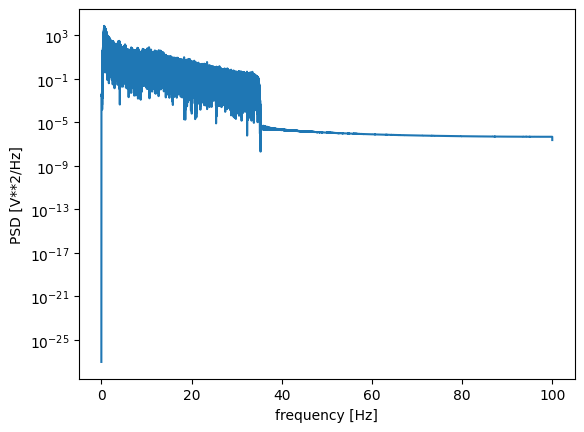

In [15]:
# Compute PSD
f, Pxx_den = signal.periodogram(eeg, fs)
plt.semilogy(f, Pxx_den)
# plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [16]:
!pip install EMD-signal

  Using cached EMD_signal-1.4.0-py3-none-any.whl (77 kB)



[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import entropy, kurtosis, skew
from scipy.signal import hilbert, periodogram, spectrogram
import nolds
from PyEMD import EMD



def extract_features(excerpt_signals, window_size=100, fs=200):
    # initialize an empty list to store the feature values
    feature_values = []

    # loop through each signal in excerpt_signals
    for i in range(excerpt_signals.shape[0]):
        signal = excerpt_signals[i, :]
        
        # calculate the total number of windows
        total_windows = signal.shape[0] // window_size
        
        # loop through each window in the signal
        for j in range(total_windows):
            # extract the window
            window = signal[j*window_size: (j+1)*window_size]
            
            # compute sample entropy
            SpEn = nolds.sampen(window, emb_dim=2, tolerance=0.05*np.std(window))

            # compute maximum and minimum
            maximum = np.max(window)
            minimum = np.min(window)

            # compute variance and standard deviation
            variance = np.var(window)
            std_deviation = np.std(window)

            # compute phase amplitude coupling
            f, t, Sxx = spectrogram(window, fs=fs)
            PAC = np.sum(Sxx[11:17,:])/np.sum(Sxx)
        
            # compute instantaneous frequency
            inst_freq = np.mean(np.diff(np.unwrap(np.angle(hilbert(window)))))/(2*np.pi)

            
            # compute energy ratio (Energy11-16Hz)
            emd = EMD()
            imfs = emd(window)

            h_imfs = np.apply_along_axis(hilbert, axis=1, arr=imfs)

            inst_freqs = np.zeros_like(h_imfs)
            for i in range(h_imfs.shape[0]):
                inst_freqs[i] = np.gradient(np.unwrap(np.angle(h_imfs[i])))

            freqs, psd = scipy.signal.welch(window, fs=fs)
            energies = np.zeros_like(imfs)
            for i in range(imfs.shape[0]):
                f_imf, p_imf = scipy.signal.welch(imfs[i], fs=fs)
                energies[i] = np.trapz(p_imf, f_imf)
            f_low, f_high = 11.0, 16.0
            idx = np.where(np.logical_and(freqs >= f_low, freqs <= f_high))
            Energy11_16Hz = np.sum(energies[:, idx], axis=1) / np.sum(energies)
            
            
            
            # compute energy ratio (Energy11-16Hz)
            f, Pxx = periodogram(window, fs=fs)
            #Energy11_16Hz = np.sum(Pxx[11:17])/np.sum(Pxx)

            # compute kurtosis and skewness
            kurt = kurtosis(window)
            skewness = skew(window)

            # compute power peak (PWRpeak)
            PWRpeak = np.max(Pxx)

            # compute power ratio (PWRratio)
            PWRratio = np.sum(Pxx[11:17])/np.sum(Pxx[:])

            # compute interquartile range (IQR)
            IQR = np.subtract(*np.percentile(window, [75, 25]))

            # compute zero crossing
            zero_crossing = len(np.where(np.diff(np.sign(window)))[0])

            # append the computed feature values to the list
            feature_values.append([SpEn, maximum, minimum, variance, std_deviation, PAC, inst_freq, Energy11_16Hz,
                                   kurt, skewness, PWRpeak, PWRratio, IQR, zero_crossing])

    # create a pandas dataframe from the list of feature values
    feature_df = pd.DataFrame(feature_values, columns=['SpEn', 'maximum', 'minimum', 'variance', 'std_deviation', 
                                                       'PAC', 'inst_freq', 'Energy11_16Hz', 'kurt', 'skewness', 
                                                       'PWRpeak', 'PWRratio', 'IQR', 'zero_crossing'])

    return feature_df


df_features = extract_features(excerpt_signals)
df_features

,SpEn,maximum,minimum,variance,std_deviation,PAC,inst_freq,Energy11_16Hz,kurt,skewness,PWRpeak,PWRratio,IQR,zero_crossing
0,3.091042,-4.868705e-05,-7.753086e-03,3.454844e-06,1.858721e-03,0.004164,-0.001094,"[[0.0006506772401941969, 0.0006506772401941969...",-0.477674,0.276506,1.094418e-06,0.014988,2.583291e-03,0
1,inf,5.689756e-03,-5.422475e-03,7.894295e-06,2.809679e-03,0.012282,0.018894,"[[0.0013591330610597534, 0.0013591330610597534...",-0.716161,-0.255083,2.217601e-06,0.013342,4.267027e-03,7
2,0.597227,7.481033e-02,2.823563e-03,4.841402e-04,2.200319e-02,0.000234,-0.000992,"[[7.129882790956411e-05, 7.129882790956411e-05...",-1.026899,0.588074,1.593872e-04,0.022406,3.783092e-02,0
3,1.791759,1.778605e-01,7.482668e-02,8.181524e-04,2.860336e-02,0.000660,-0.000665,"[[0.00023283262672696767, 0.000232832626726967...",-1.122784,-0.089517,2.402906e-04,0.020090,4.705814e-02,0
4,0.536305,1.818140e-01,-3.264030e-02,2.101107e-03,4.583784e-02,0.003454,-0.001320,"[[0.00024993662962668925, 0.000249936629626689...",1.375114,-1.322712,5.949377e-04,0.051021,5.916224e-02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,inf,3.262406e+07,-3.106363e+07,1.726147e+14,1.313829e+07,0.132083,0.028943,"[[0.005234896026620706, 0.005234896026620706, ...",0.545192,-0.831387,2.967296e+13,0.121649,1.731580e+07,11
28796,inf,3.861549e+07,-4.488254e+07,2.795103e+14,1.671856e+07,0.338078,0.068598,"[[0.006518184940845575, 0.006518184940845575, ...",0.129805,-0.430240,5.070959e+13,0.295904,2.085341e+07,17
28797,1.540445,3.992002e+07,-7.780565e+07,7.262763e+14,2.694951e+07,0.062039,0.009110,"[[0.001472797952351973, 0.001472797952351973, ...",-0.559498,-0.143479,2.842681e+14,0.069864,3.835055e+07,8
28798,1.609438,7.368973e+07,3.103479e+06,2.761549e+14,1.661791e+07,0.153932,-0.000339,"[[0.002737878860643896, 0.002737878860643896, ...",-0.433205,-0.117004,4.175819e+13,0.192646,2.054396e+07,0


In [26]:
df_features.Energy11_16Hz

0        [[0.0006506772401941969, 0.0006506772401941969...
1        [[0.0013591330610597534, 0.0013591330610597534...
2        [[7.129882790956411e-05, 7.129882790956411e-05...
3        [[0.00023283262672696767, 0.000232832626726967...
4        [[0.00024993662962668925, 0.000249936629626689...
                               ...                        
28795    [[0.005234896026620706, 0.005234896026620706, ...
28796    [[0.006518184940845575, 0.006518184940845575, ...
28797    [[0.001472797952351973, 0.001472797952351973, ...
28798    [[0.002737878860643896, 0.002737878860643896, ...
28799    [[0.0031059645827533474, 0.0031059645827533474...
Name: Energy11_16Hz, Length: 28800, dtype: object

In [ ]:
# Count infinite values in SpEn feature
print('infinites in SpEn:', df_features.SpEn.loc[df_features['SpEn'] == np.inf].count())

In [ ]:
# Get the maximum value besides infinite in SpEn
print('Get maximum value besides SpEn:', df_features.SpEn.loc[df_features['SpEn'] != np.inf].max())

In [ ]:
# Cap the infinites to the maximum values besides it

df_features.loc[df_features['SpEn'] == np.inf, 'SpEn'] = df_features.SpEn.loc[df_features['SpEn'] != np.inf].max()

In [ ]:
# Check for null values created by mistake
df_features.isna().sum()

In [ ]:
# TODO 
# In particular, instantaneous frequency and energy ratio were obtained using Hilbert-Huang transform.
# Kurtosis, skewness, power peak and power ratio values were computed on the power spectral density (PSD) of the signal.
# Interquartile range and zero crossing were calculated on the first mode of the empirical mode decomposition (EMD) of the filtered signal.

In [ ]:
# Define the label


# Modelling

In [ ]:
# Splitting the data:
# x_train, x_test, y_train, y_test = train_test_split(df.drop(target, axis=1),
#                                                         df[target],
#                                                         test_size=0.33,
#                                                         random_state=42)

In [ ]:
from sklearn.svm import SVC

# model = SVC(random_state=42)

# model.fit(X_train, y_train)

In [ ]:
# from __future__ import annotations
# import pandas as pd
# # Modelling:
# from hyperopt import hp, Trials, fmin, STATUS_OK, tpe
# from sklearn.metrics import f1_score, make_scorer
# from sklearn.model_selection import cross_val_score, StratifiedKFold


# def objective(space, x_train: pd.DataFrame, y_train: pd.DataFrame, x_test: pd.DataFrame, y_test: pd.DataFrame,
#               cross_validation: int = 5, fast: bool = False):

#     model = SVC(C=space['C'],
#                 kernel=space['kernel'],
#                 degree=space['degree'],
#                 gamma=space['gamma'],
#                 random_state=42)

#     # define the model evaluation data
#     X = pd.concat([x_train, x_test])
#     y = pd.concat([y_train, y_test])

#     # since we have an imbalanced dataset, we need to use stratified k-fold cross-validation:
#     cv = StratifiedKFold(n_splits=cross_validation, shuffle=True, random_state=42)

#     if fast:
#         cv = 2

#     # since we are interested in churners, the positive class, the f1 is a good metric:
#     metric = make_scorer(f1_score)

#     # evaluate the model:
#     f1 = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1).mean()

#     # return the loss, 1 - f1 score since we want to maximize the f1 score:
#     return {'loss': 1 - f1, 'status': STATUS_OK}


# def tuner(x_train: pd.DataFrame, y_train: pd.DataFrame,
#           x_test: pd.DataFrame, y_test: pd.DataFrame, max_evaluations: int = 100,
#           cross_validation: int = 5, fast: bool = False):

#     # define the search space, choose the parameters to tune:
#     space = {
#         'C': hp.uniform('C', 0.1, 1),
#         'kernel': hp.choice('kernel', ['linear', 'rbf', 'sigmoid', 'poly']),
#         'degree': hp.choice('degree', [2, 3, 4, 5, 6]),
#     }

#     # define the trials object:
#     trials = Trials()

#     # run the optimization:
#     best = fmin(fn=lambda search_space: objective(search_space, x_train, y_train, x_test, y_test,
#                                                   cross_validation, fast),
#                 space=space, algo=tpe.suggest, max_evals=max_evaluations, trials=trials)

#     # filter out the parameters that are 0:
#     best = {k: v for k, v in best.items() if v != 0}

#     return best

# # tune the model:
# best = tuner(x_train, y_train, x_test, y_test, max_evaluations=100, cross_validation=5, fast=False)
# print(best)

# # train the model with the best parameters:
# model = SVC(**best, random_state=42)
# model.fit(x_train, y_train)

# # train the model:
# model.fit(x_train, y_train)

# # evaluate the model:
# y_pred = model.predict(x_test)
# print(f1_score(y_test, y_pred))